In [2]:
import os
import sys
os.environ["PYSPARK_SUBMIT_ARGS"]='pyspark-shell'
os.environ["PYSPARK_PYTHON"]='python3'
os.environ["SPARK_HOME"]='/usr/hdp/current/spark2-client'

spark_home = os.environ.get('SPARK_HOME', None)
if not spark_home:
    raise ValueError('SPARK_HOME environment variable is not set')
sys.path.insert(0, os.path.join(spark_home, 'python'))
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.4-src.zip'))
os.environ["PYSPARK_PYTHON"] = 'python3'
exec(open(os.path.join(spark_home, 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.0
      /_/

Using Python version 3.6.4 (default, Jan 28 2018 00:00:00)
SparkSession available as 'spark'.


In [ ]:
spark.stop()

In [4]:
from IPython.display import Image

## Pipeline

+ **DataFrame**: This ML API uses DataFrame from Spark SQL as an ML dataset, which can hold a variety of data types. E.g., a DataFrame could have different columns storing text, feature vectors, true labels, and predictions.


+ **Transformer**: A Transformer is an algorithm which can transform one DataFrame into another DataFrame. E.g., an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.


+ **Estimator**: An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer. E.g., a learning algorithm is an Estimator which trains on a DataFrame and produces a model.


+ **Pipeline**: A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow.


+ **Parameter**: All Transformers and Estimators now share a common API for specifying parameters.

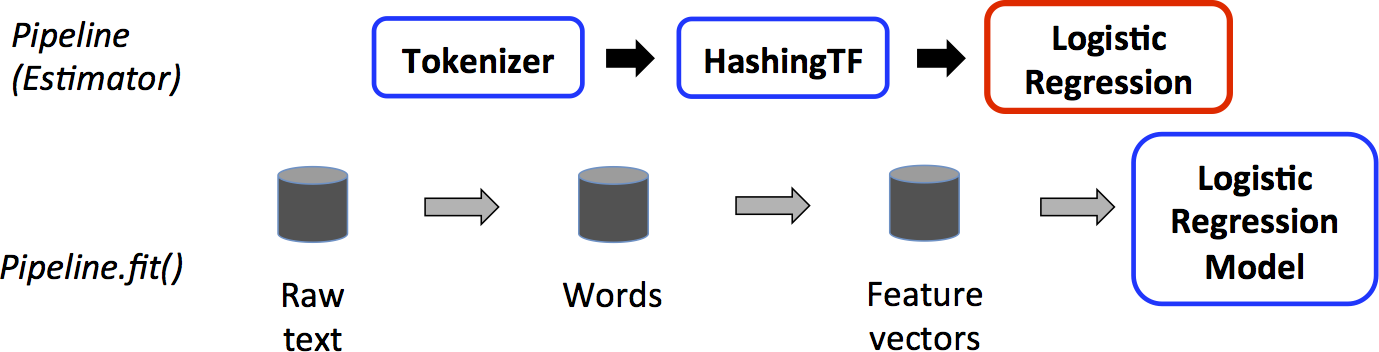

In [5]:
Image("pics/ml-Pipeline.png")

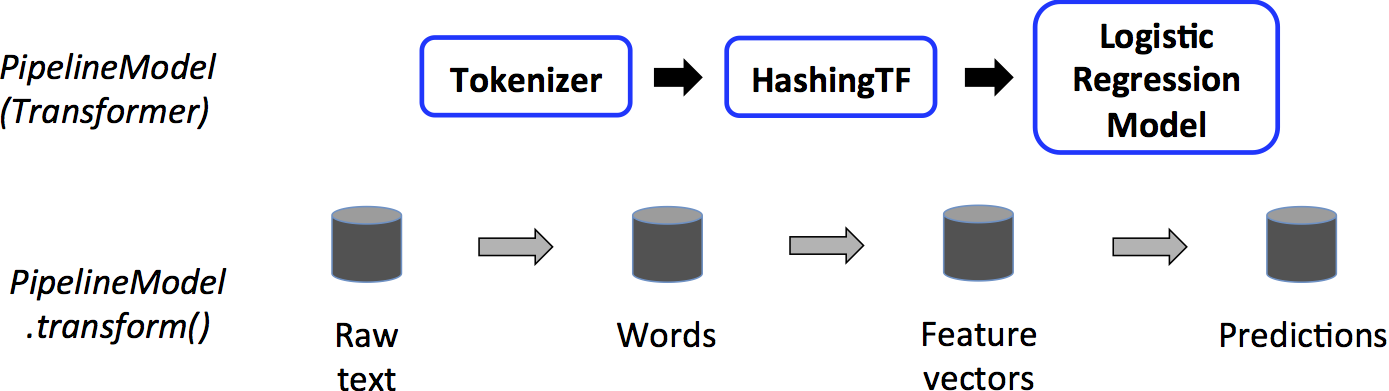

In [6]:
Image("pics/ml-PipelineModel.png")

In [7]:
from pyspark.ml.linalg import Vectors

In [8]:
from pyspark.ml.classification import LogisticRegression

In [9]:
training = spark.createDataFrame([
    (1.0, Vectors.dense([0.0, 1.1, 0.1])),
    (0.0, Vectors.dense([2.0, 1.0, -1.0])),
    (0.0, Vectors.dense([2.0, 1.3, 1.0])),
    (1.0, Vectors.dense([0.0, 1.2, -0.5]))], schema = ["label", "features"])

In [10]:
lr = LogisticRegression(maxIter=10, regParam=0.01)

In [11]:
lr

LogisticRegression_476999209567f2ad2df4

In [12]:
lr.params

[Param(parent='LogisticRegression_476999209567f2ad2df4', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'),
 Param(parent='LogisticRegression_476999209567f2ad2df4', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'),
 Param(parent='LogisticRegression_476999209567f2ad2df4', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'),
 Param(parent='LogisticRegression_476999209567f2ad2df4', name='featuresCol', doc='features column name.'),
 Param(parent='LogisticRegression_476999209567f2ad2df4', name='fitIntercept', doc='whether to fit an intercept term.'),
 Param(parent='LogisticRegression_476999209567f2ad2df4', name='labelCol', doc='label column name.'),
 Param(parent='LogisticRegression_476999209567f2ad2df4', name='lowerBoundsOnCoefficients', doc='The 

In [14]:
model = lr.fit(training)

In [19]:
model.coefficients

DenseVector([-3.1009, 2.6082, -0.3802])

In [23]:
model.interceptVector

DenseVector([0.0682])

## Toxic Comment Classification Challenge

In [24]:
from pyspark.sql.types import *

In [25]:
schema = StructType([
    StructField("id", StringType()),
    StructField("comment_text", StringType()),
    StructField("toxic", IntegerType()),
    StructField("severe_toxic", IntegerType()),
    StructField("obscene", IntegerType()),
    StructField("threat", IntegerType()),
    StructField("insult", IntegerType()),
    StructField("identity_hate", IntegerType())
])

In [26]:
dataset = spark.read.csv("/user/pavel.klemenkov/data/lecture03/toxic_comment/train.csv", schema=schema, header=True)

In [27]:
dataset.show(1)

+----------------+------------+-----+------------+-------+------+------+-------------+
|              id|comment_text|toxic|severe_toxic|obscene|threat|insult|identity_hate|
+----------------+------------+-----+------------+-------+------+------+-------------+
|0000997932d777bf| Explanation| null|        null|   null|  null|  null|         null|
+----------------+------------+-----+------------+-------+------+------+-------------+
only showing top 1 row



## There is an issue with multiline CSVs, fixed in 2.2.0 https://issues.apache.org/jira/browse/SPARK-19610

In [28]:
!head -n3 toxic_comment/train.csv

"id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"
"0000997932d777bf","Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0


In [29]:
dataset = spark.read.csv("/user/pavel.klemenkov/data/lecture03/toxic_comment/train.csv", schema=schema, header=True, multiLine=True)

In [30]:
dataset.select("id").show(10)

+--------------------+
|                  id|
+--------------------+
|    0000997932d777bf|
|    000103f0d9cfb60f|
|    000113f07ec002fd|
|    0001b41b1c6bb37e|
|                More|
|I can't make any ...|
|There appears to ...|
|    0001d958c54c6e35|
|    00025465d4725e87|
|Congratulations f...|
+--------------------+
only showing top 10 rows



## Still no luck with CSV reader (( If someone finds a solution, please share it!

In [31]:
import pandas as pd

In [32]:
df = pd.read_csv("toxic_comment/train.csv")
df.fillna("", inplace=True)

In [33]:
df[["id", "comment_text"]][:10]

,id,comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ..."
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...
9,00040093b2687caa,alignment on this subject and which are contra...


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [35]:
dataset = spark.createDataFrame(df, schema=schema)

In [36]:
dataset

DataFrame[id: string, comment_text: string, toxic: int, severe_toxic: int, obscene: int, threat: int, insult: int, identity_hate: int]

In [37]:
dataset.rdd.getNumPartitions()

2

In [38]:
dataset.count()

159571

In [39]:
dataset = dataset.repartition(4).cache()

## Let's define a binary target (toxic/non-toxic)

In [42]:
from pyspark.sql import functions as f

In [43]:
target = f.when(
    (dataset.toxic == 0) &
    (dataset.severe_toxic == 0) &
    (dataset.obscene == 0) &
    (dataset.threat == 0) &
    (dataset.insult == 0) &
    (dataset.identity_hate == 0),
    0
).otherwise(1)

In [44]:
dataset = dataset.withColumn("target", target)

In [45]:
dataset.select("id", "target").show(10)

+----------------+------+
|              id|target|
+----------------+------+
|6fdb7b6734f8bf40|     0|
|39b742437bd11ec9|     0|
|9bbb8e1922fe1efb|     0|
|54f9e59924682c6e|     0|
|62e38775721eb79e|     1|
|25553d990b245467|     1|
|7b65f1b25caab0cc|     0|
|4d04d14d5b9b4b00|     1|
|9fc8c85c45176539|     0|
|95e766cf6e954b40|     0|
+----------------+------+
only showing top 10 rows



In [46]:
dataset.groupBy("target").count().collect()

[Row(target=1, count=16225), Row(target=0, count=143346)]

In [47]:
16225 / (16225 + 143346)

0.10167887648758234

In [48]:
dataset = dataset.drop("toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate").cache()

In [49]:
dataset

DataFrame[id: string, comment_text: string, target: int]

In [50]:
dataset.show(5, False, True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id           | 6fdb7b6734f8bf40                                                                                                                                                                                                                                          

In [ ]:
dataset.write.parquet("/user/pavel.klemenkov/data/lecture03/toxic_comment/dataset")

## Let's fit the simplest binary-BoW logistic regression

In [51]:
from pyspark.ml.feature import *

## Split comments into words

In [53]:
tokenizer = Tokenizer(inputCol="comment_text", outputCol="words")

In [54]:
dataset2 = tokenizer.transform(dataset)

In [57]:
dataset2.select("id", "words").show(5, False, True)

-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 id    | 6fdb7b6734f8bf40                                                                                                                           

In [59]:
type(dataset2.take(1)[0].words)

list

## Convert texts into binary vectors using Hashing trick

In [62]:
hasher = HashingTF(numFeatures=100, binary=True, inputCol=tokenizer.getOutputCol(), outputCol="word_vector")
dataset2 = hasher.transform(dataset2)

In [63]:
dataset2.select("id", "word_vector").show(5)

+----------------+--------------------+
|              id|         word_vector|
+----------------+--------------------+
|6fdb7b6734f8bf40|(100,[0,3,5,10,12...|
|39b742437bd11ec9|(100,[0,1,2,3,10,...|
|9bbb8e1922fe1efb|(100,[10,35,70,91...|
|54f9e59924682c6e|(100,[3,4,19,21,2...|
|62e38775721eb79e|(100,[16,25,26,30...|
+----------------+--------------------+
only showing top 5 rows



## Now let's split into train and test. Don't forget that we have imbalanced classes, so let's do stratified sampling

In [64]:
train = dataset2.sampleBy("target", fractions={0: 0.8, 1: 0.8})

In [65]:
train.groupby("target").count().collect()

[Row(target=1, count=12987), Row(target=0, count=114503)]

In [66]:
13005 / (13005 + 114361)

0.10210731278363143

In [67]:
test = dataset2.join(train, on="id", how="leftanti")

In [68]:
test.groupby("target").count().collect()

[Row(target=1, count=3238), Row(target=0, count=28843)]

In [69]:
3220 / (3220 + 28985)

0.0999844744604875

In [70]:
train.rdd.getNumPartitions()

4

In [71]:
test.rdd.getNumPartitions()

200

In [72]:
train

DataFrame[id: string, comment_text: string, target: int, words: array<string>, word_vector: vector]

In [73]:
train = train.drop("comment_text", "words").cache()

In [74]:
test = test.drop("comment_text", "words").repartition(4).cache()

## Let's fit logistic regression

In [75]:
from pyspark.ml.classification import LogisticRegression

In [76]:
lr = LogisticRegression(featuresCol=hasher.getOutputCol(), labelCol="target", maxIter=15)

In [77]:
lr_model = lr.fit(train)

In [78]:
predictions = lr_model.transform(test)

In [79]:
predictions

DataFrame[id: string, target: int, word_vector: vector, rawPrediction: vector, probability: vector, prediction: double]

In [80]:
predictions.select("id", "target", "prediction", "probability").show(20)

+----------------+------+----------+--------------------+
|              id|target|prediction|         probability|
+----------------+------+----------+--------------------+
|5dc95dec5ade2c4a|     0|       0.0|[0.95211030400663...|
|aef3e79ac7f80335|     0|       0.0|[0.88788485383158...|
|2c3995a6fa633106|     0|       0.0|[0.93119922354919...|
|9a8ee3ee4ec933e3|     0|       0.0|[0.90809126610492...|
|f113ae398d198327|     0|       0.0|[0.96730432878269...|
|928393bab91b3343|     0|       0.0|[0.86115737836718...|
|bd2d8a0981db4a5d|     1|       0.0|[0.73712532175035...|
|af9db4bc73488aca|     0|       0.0|[0.69619196189089...|
|56bb99a4ee14f736|     0|       0.0|[0.96946461141995...|
|622356793264dbb6|     0|       0.0|[0.98952674982477...|
|332c60273a8f9087|     0|       0.0|[0.92432107324086...|
|bfac5153daaa45e5|     0|       0.0|[0.96528356417774...|
|1f21ceecb1dc2492|     0|       0.0|[0.99147411524520...|
|297517dbd3eda0e8|     0|       0.0|[0.97293747281195...|
|c5037d165ff75

In [81]:
predictions.select("target", f.col("prediction").cast("int")).filter("target == prediction").count()

28864

In [82]:
predictions.count()

32081

In [83]:
print("Accuracy is {}".format(28864 / 32081))

Accuracy is 0.8997225772263957


## What if we want more sophisticated metrics?

In [84]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [85]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="target", metricName='areaUnderROC')

In [86]:
evaluator.evaluate(predictions)

0.5162654448160783

In [87]:
evaluator.setParams(metricName="areaUnderPR")

BinaryClassificationEvaluator_411f936be73d2006969f

In [88]:
evaluator.evaluate(predictions)

0.33338711653902964

In [89]:
lr.getThreshold()

0.5

In [90]:
evaluator.setParams(metricName="precision")

BinaryClassificationEvaluator_411f936be73d2006969f

In [91]:
evaluator.evaluate(predictions)

IllegalArgumentException: 'BinaryClassificationEvaluator_411f936be73d2006969f parameter metricName given invalid value precision.'

## `spark.ml.evaluation.BinaryClassificationEvaluator` supports only ROC AUC and PR AUC. What if we want more?

In [92]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [93]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="target", metricName="accuracy")

In [94]:
evaluator.evaluate(predictions)

0.8997225772263957

In [96]:
evaluator = evaluator.setMetricName("weightedPrecision")

In [97]:
evaluator.evaluate(predictions)

0.8664835580910804

In [98]:
evaluator = evaluator.setMetricName("weightedRecall")

In [99]:
evaluator.evaluate(predictions)

0.8997225772263957

In [106]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, confusion_matrix

In [101]:
predictions_df = predictions.toPandas()

RuntimeError: Unsupported type in conversion to Arrow: VectorUDT
Note: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true. Please set it to false to disable this.

In [102]:
spark.sql("SET spark.sql.execution.arrow.enabled=false")

DataFrame[key: string, value: string]

In [103]:
predictions_df = predictions.toPandas()

In [104]:
precision_score(predictions_df.target, predictions_df.prediction.astype("int"))

0.5497630331753555

In [105]:
recall_score(predictions_df.target, predictions_df.prediction.astype("int"))

0.035824583075972825

In [107]:
confusion_matrix(predictions_df.target, predictions_df.prediction.astype("int"))

array([[28748,    95],
       [ 3122,   116]])

In [109]:
predictions.select("target", f.col("prediction").cast("int")).filter("target = 1").count()

3238

In [ ]:
predictions_df.head()

In [ ]:
precision_recall_curve()

## Let's define a pipeline!

In [111]:
dataset = spark.read.parquet("/user/pavel.klemenkov/data/lecture03/toxic_comment/dataset")

In [112]:
dataset

DataFrame[id: string, comment_text: string, target: int]

In [113]:
dataset.rdd.getNumPartitions()

4

In [114]:
from pyspark.ml import Pipeline

In [115]:
pipeline = Pipeline(stages=[
    tokenizer,
    hasher,
    lr
])

In [116]:
train = dataset.sampleBy("target", fractions={0: 0.8, 1: 0.8}).cache()

In [117]:
test = dataset.join(train, on="id", how="leftanti").cache()

In [118]:
pipeline_model = pipeline.fit(train)

In [119]:
predictions = pipeline_model.transform(test)

In [120]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="target", metricName='areaUnderROC')

In [121]:
evaluator.evaluate(predictions)

0.5185136310633601

## Okay, may be some more sophisticated stuff?

In [123]:
from pyspark.ml.classification import GBTClassifier

In [124]:
gbt = GBTClassifier(featuresCol=hasher.getOutputCol(), labelCol="target")

In [125]:
pipeline = Pipeline(stages=[
    tokenizer,
    hasher,
    gbt
])

In [126]:
pipeline_model = pipeline.fit(train)

In [127]:
predictions = pipeline_model.transform(test)

In [128]:
evaluator.evaluate(predictions)

0.5059978081798852

## Lets add more degrees of freedom

In [138]:
pipeline_model.stages[1].extractParamMap()

{Param(parent='HashingTF_425797739d80b0a069cd', name='outputCol', doc='output column name.'): 'word_vector',
 Param(parent='HashingTF_425797739d80b0a069cd', name='numFeatures', doc='number of features.'): 100,
 Param(parent='HashingTF_425797739d80b0a069cd', name='binary', doc='If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts. Default False.'): True,
 Param(parent='HashingTF_425797739d80b0a069cd', name='inputCol', doc='input column name.'): 'words'}

In [ ]:
pipeline_model = pipeline.fit(train, params={hasher.numFeatures: 1000})

In [143]:
pipeline_model.stages[1].extractParamMap()

{Param(parent='HashingTF_425797739d80b0a069cd', name='binary', doc='If True, all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts. Default False.'): True,
 Param(parent='HashingTF_425797739d80b0a069cd', name='numFeatures', doc='number of features.'): 1000,
 Param(parent='HashingTF_425797739d80b0a069cd', name='outputCol', doc='output column name.'): 'word_vector',
 Param(parent='HashingTF_425797739d80b0a069cd', name='inputCol', doc='input column name.'): 'words'}

In [144]:
predictions = pipeline_model.transform(test)

In [145]:
evaluator.evaluate(predictions)

0.5943694438035614

## Let's remove stopwords

In [147]:
stop_words = StopWordsRemover.loadDefaultStopWords("english")

In [148]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 'her',
 'hers',
 'herself',
 'it',
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each',
 'few',
 'more',
 'most',
 'other',
 'some',
 'such',
 'no',
 'nor',
 '

In [149]:
swr = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="words_filtered", stopWords=stop_words)

In [150]:
hasher = HashingTF(numFeatures=1000, binary=True, inputCol=swr.getOutputCol(), outputCol="word_vector")

In [151]:
pipeline = Pipeline(stages=[
    tokenizer,
    swr,
    hasher,
    lr
])

In [152]:
pipeline_model = pipeline.fit(train)

In [153]:
pipeline_model.stages

[Tokenizer_4e449f0728e88adbb2cd,
 StopWordsRemover_4cfab036287b4c4871b4,
 HashingTF_4c4792648d73244be4ce,
 LogisticRegression_4807b3183c8fe8b351cc]

In [154]:
predictions = pipeline_model.transform(test)

In [155]:
evaluator.evaluate(predictions)

0.6378196794060365

## Need moar features!

In [158]:
dataset = dataset.withColumn("comment_length", f.length(dataset.comment_text))

In [160]:
train = dataset.sampleBy("target", fractions={0: 0.8, 1: 0.8}).cache()
test = dataset.join(train, on="id", how="leftanti").cache()

In [162]:
assembler = VectorAssembler(inputCols=[hasher.getOutputCol(), "comment_length"], outputCol="features")

In [163]:
lr = LogisticRegression(labelCol="target", maxIter=15)

In [164]:
pipeline = Pipeline(stages=[
    tokenizer,
    swr,
    hasher,
    assembler,
    lr
])

In [165]:
pipeline_model = pipeline.fit(train)

In [166]:
pipeline_model.stages

[Tokenizer_4e449f0728e88adbb2cd,
 StopWordsRemover_4cfab036287b4c4871b4,
 HashingTF_4c4792648d73244be4ce,
 VectorAssembler_468a8ceb97d995e39d25,
 LogisticRegression_4e4daa8be45535187b5c]

In [167]:
predictions = pipeline_model.transform(test)

In [168]:
evaluator.evaluate(predictions)

0.6388529942983864

In [173]:
pipeline_model.stages[-1].coefficients[-1]

0.0007202833320375108

## Ok, how do you do it right!? https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/52557

## Very funny, anyway?

In [176]:
count_vectorizer = CountVectorizer(inputCol=swr.getOutputCol(), outputCol="word_vector", binary=True)

In [177]:
assembler = VectorAssembler(inputCols=[count_vectorizer.getOutputCol(), "comment_length"], outputCol="features")

In [178]:
pipeline = Pipeline(stages=[
    tokenizer,
    swr,
    count_vectorizer,
    assembler,
    lr
])

In [179]:
pipeline_model = pipeline.fit(train)

In [180]:
predictions = pipeline_model.transform(test)

In [181]:
evaluator.evaluate(predictions)

0.8276641115345744

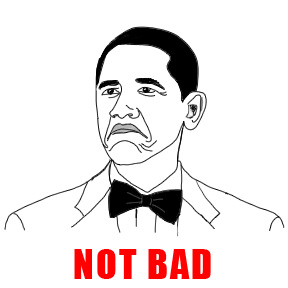

In [182]:
Image("pics/Obama_not_bad.png")

## Hyperparameter tuning

In [184]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [186]:
paramGrid = ParamGridBuilder().addGrid(count_vectorizer.vocabSize, [100, 500, 1000])\
                              .addGrid(lr.regParam, [0.01, 0.05, 0.1])\
                              .build()

In [187]:
crossval = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

In [188]:
cv_model = crossval.fit(train)

In [189]:
cv_model.

CrossValidatorModel_414ba73e57cbc6ff1d8a

In [190]:
predictions = cv_model.transform(test)

In [191]:
evaluator.evaluate(predictions)

0.6998806156441523